In [104]:
import numpy as np
import pandas as pd
from scipy.stats import norm, entropy, ecdf, kstest, cramervonmises, kstwo
import matplotlib.pyplot as plt

import pickle
import json
from scipy.stats import gamma

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2, QiskitRuntimeService


import time
import os

In [ ]:
def create_circuit(n_step, n_depth, n_data, n_bath):
    n_wires = n_data + n_bath
    n_param = 2 * n_depth * n_step
    n_register = n_data + n_bath * n_step

    # circuit parameter storages
    param_data = [ParameterVector(f'data_{i}', length=n_param) for i in range(n_data)]
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    c = ClassicalRegister(n_register, 'c')
    circuit = QuantumCircuit(q, c)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            for i in range(n_data):
                circuit.ry(param_data[i][param_id], i)
                circuit.rz(param_data[i][param_id + 1], i)

            for b in range(n_bath):
                circuit.ry(param_bath[b][param_id], n_data + b)
                circuit.rz(param_bath[b][param_id + 1], n_data + b)

            for i in range(n_wires//2):
                circuit.cx(2*i, 2*i+1)

            for i in range((n_wires - 1)//2):
                circuit.cx(2*i+1, 2*i+2)

        register_id = n_data + t * n_bath
        circuit.measure(range(n_data, n_wires), range(
            register_id, register_id + n_bath))

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(n_data + b)

    circuit.measure(range(n_data), range(n_data))

    return circuit

In [34]:
def count_merge(bit_string_counts):
    counts = {}
    for d in bit_string_counts:
        for key, value in d.items():
            counts[key] = counts.get(key, 0) + value
    return counts

In [2]:
def get_cond_prob(bit_string_counts, n_data):
    # convert count dict to pd frame
    df = pd.DataFrame.from_dict(
        bit_string_counts, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['data_bits'] = df['bits'].str[-n_data:]
    df['bath_bits'] = df['bits'].str[:-n_data]
    df = df.drop('bits', axis=1)

    # find result with 00 data bit
    A0_bits = df[df['data_bits'] == '0'*n_data]
    A0_bits = A0_bits.rename(
        columns={'counts': 'cond_counts'}).drop('data_bits', axis=1)

    # compute cond prob using left merge
    ZB_df = df.groupby('bath_bits').sum(numeric_only=True).reset_index()
    ZB_df = ZB_df.merge(A0_bits, on='bath_bits', how='left').fillna(0)
    ZB_df['cond_prob'] = ZB_df['cond_counts'] / ZB_df['counts']
    ZB_df = ZB_df.drop(['cond_counts', 'bath_bits'], axis=1)

    # expand into long format
    #ZB_df = ZB_df.reindex(ZB_df.index.repeat(ZB_df['counts']))
    
    return ZB_df['cond_prob'].to_numpy()

In [3]:
def count_clip(count_dict, n_data, threshold):
    df = pd.DataFrame.from_dict(
        count_dict, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['data_bits'] = df['bits'].str[-n_data:]
    df['bath_bits'] = df['bits'].str[:-n_data]
    df = df.drop('bits', axis=1)

    ZB_df = df.groupby('bath_bits').sum(numeric_only=True).reset_index()
    ZB_clip = ZB_df[ZB_df['counts'] < threshold]

    df_filtered = df[~df['bath_bits'].isin(ZB_clip['bath_bits'])].copy()
    df_filtered['bits'] = df_filtered['bath_bits'] + df_filtered['data_bits']
    df_filtered = df_filtered.drop('data_bits', axis=1)
    df_filtered = df_filtered.drop('bath_bits', axis=1)
    
    count_filtered_dict = df_filtered.set_index('bits')['counts'].to_dict()
    return count_filtered_dict

In [152]:
def gaussian_pdf(x, sample, bandwidth):
    f = np.subtract.outer(x, sample)/bandwidth
    f = np.mean(norm.pdf(f), axis=1)/bandwidth
    return f

def gaussian_cdf(x, sample, bandwidth):
    f = np.subtract.outer(x, sample)/bandwidth
    f = np.mean(norm.cdf(f), axis=1)
    return f

In [31]:
def pt_density(x, n):
    return (2 ** n - 1) * (1 - x) ** (2 ** n - 2)

def pt_cdf(x, n):
    return 1. - (1.-x)**(2**n-1.)

In [68]:
def count_readoutError(count_id, r):
    # consider single-bit readout error
    prob = {}
    shot = sum(count_id.values())
    for key, value in count_id.items():
        for pos in range(len(key)):
            flip_bit = '0' if key[pos] == '1' else '1'
            key_err = key[:pos] + flip_bit + key[pos+1:]
            prob[key_err] = prob.get(key_err, 0) + value/shot*r
        prob[key] = prob.get(key, 0) + value/shot * (1.-len(key)*r)
    
    
    #res_ints = [int(x, 2) for x in prob.keys()]
    samples = np.random.choice(len(prob.keys()), size=shot, replace=True, p=list(prob.values()))
    count = {}
    keys = list(prob.keys())
    for x in samples:
        key = keys[x]
        count[key] = count.get(key, 0) + 1

    return count

## 2 Qubits, HEA circuit

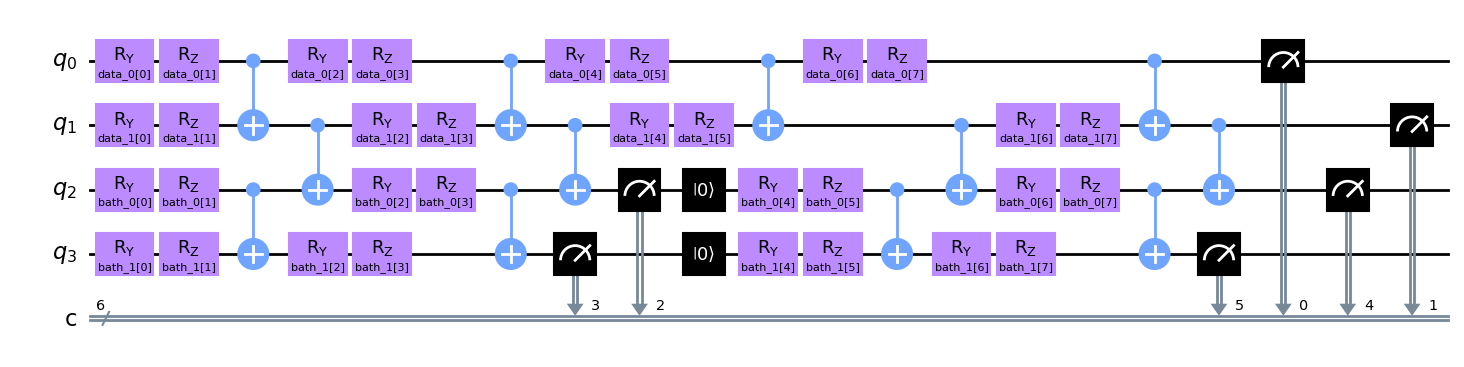

In [4]:
# plot a simple circuit
circuit = create_circuit(2, 2, 2)
circuit.draw('mpl')

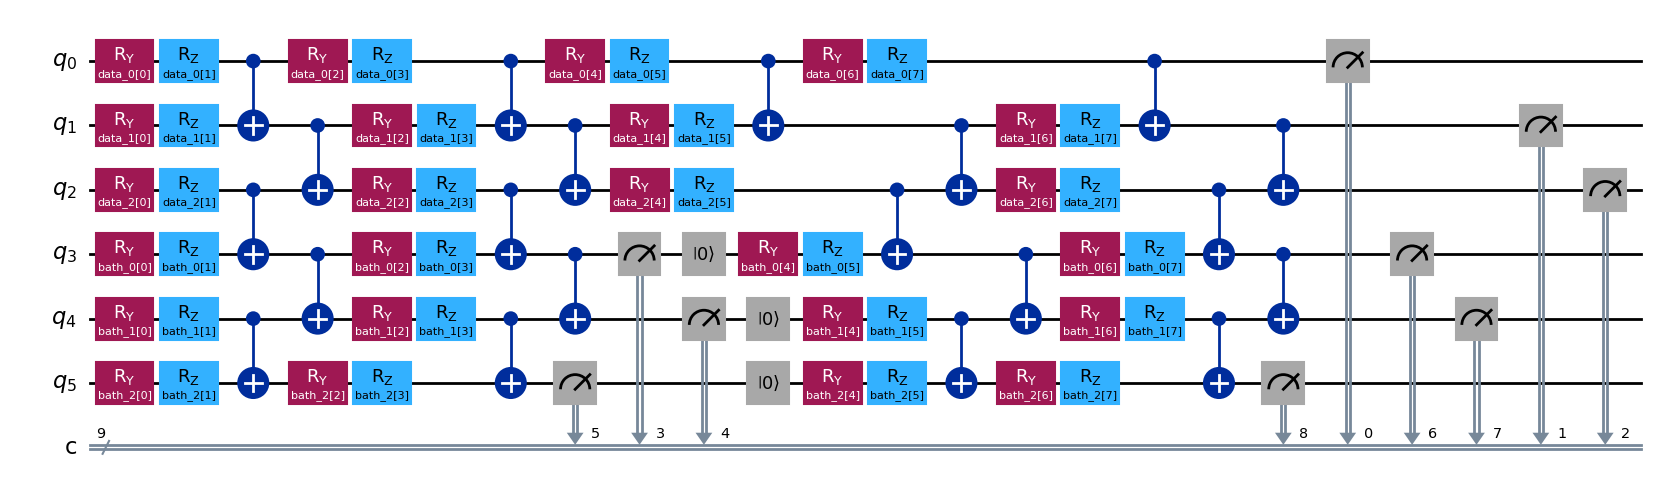

In [33]:
circuit = create_circuit(2, 2, 3, 3)
circuit.draw('mpl')

# PoP dynamics simulation

In [7]:
n_data = 5
n_bath = 3
n_depth = (n_data + n_bath)
n_shot = 1e5


path = f"data/experiment/PoP/ideal/Na{n_data}"
if not os.path.exists(path):
    os.makedirs(path)

res_all = []
for n_step in [1, 2, 4]:
    t0 = time.time()
    np.random.seed(1)
    circuit = create_circuit(n_step, n_depth, n_data, n_bath)

    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = circuit.assign_parameters(param_random)

    # simulate
    job = AerSimulator().run(bound_circuit, shots=n_shot)
    res = job.result().get_counts(bound_circuit)
    res_all.append(res)
    print(f'step={n_step}, time={time.time() - t0:.3f}')
with open(os.path.join(path, f'count_Na{n_data}Nb{n_bath}L{n_depth}.pkl'), "wb") as file:
    pickle.dump(res_all, file)

step=1, time=0.611
step=2, time=12.131
step=4, time=22.354


In [39]:
token = open('IBMQ_token_usc.txt','r').read()
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token=token
)

In [ ]:
backend_name = 'sherbrooke'
backend = service.backend(f"ibm_{backend_name}")
backend_sim = AerSimulator.from_backend(backend)

In [ ]:
# new circuit
n_data = 5
n_bath = 5
n_depth = n_data + n_bath
n_shot = 1e6

path = f'data/experiment/PoP/{backend_name}Simu/Na{n_data}'
if not os.path.exists(path):
    os.makedirs(path)

res_all = []

for n_step in [1]:
    t0 = time.time()
    circuit = create_circuit(n_step, n_depth, n_data, n_bath)
    transpiled_circuit = transpile(circuit, backend)
    
    np.random.seed(1)
    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = transpiled_circuit.assign_parameters(param_random)
    
    job = backend_sim.run(bound_circuit, shots=n_shot)
    res = job.result().get_counts(bound_circuit)
    res_all.append(res)
    print(f'step={n_step}, time={time.time() - t0:.3f}')
    
with open(os.path.join(path, f"count_Na{n_data}Nb{n_bath}L{n_depth}.pkl"), "wb") as file:
    pickle.dump(res_all, file)

In [39]:
# separate result
n_data = 5
n_bath = 3
n_depth = (n_data + n_bath)

#path = f'data/experiment/PoP/ideal/Na{n_data}'
path = f'data/experiment/PoP/brisbaneSimu/Na{n_data}'

with open(os.path.join(path, f'count_Na{n_data}Nb{n_bath}L{n_depth}_1e5.pkl'), 'rb') as file:
    load_data = pickle.load(file)

step = [1, 2, 4]
for i in range(3):
    condP = []
    for k in range(10):
        phat = get_cond_prob(load_data[k][i], n_data)
        condP.append(phat)
    np.savez(os.path.join(path, f'condP_Na{n_data}Nb{n_bath}L{n_depth}T{step[i]}'), *condP)

In [46]:
# merge result
n_data = 5
n_bath = 3
n_depth = (n_data + n_bath)

#path = f'data/experiment/PoP/ideal/Na{n_data}'
path = f'data/experiment/PoP/brisbaneSimu/Na{n_data}'

with open(os.path.join(path, f'count_Na{n_data}Nb{n_bath}L{n_depth}_1e5.pkl'), 'rb') as file:
    load_data = pickle.load(file)

condP = []
for i in range(3):
    counts = [load_data[k][i] for k in range(10)]
    res = count_merge(counts)
    phat = get_cond_prob(res, n_data)
    condP.append(phat)
np.savez(os.path.join(path, f'condP_Na{n_data}Nb{n_bath}L{n_depth}_merge'), *condP)

# Simulation results

Text(0.5, 1.0, 'Noiseless, Na=2, Nb=2, L=4, shots=1e6')

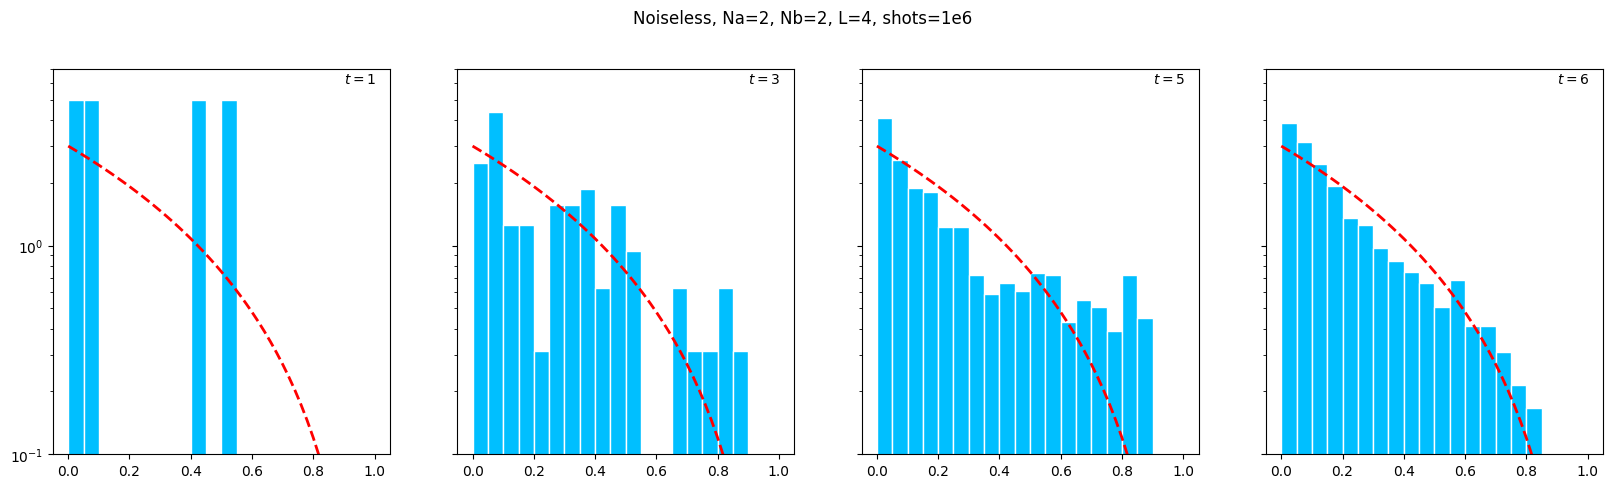

In [18]:
n_data, n_bath = 2, 2
n_depth = n_data + n_bath
step = [1, 3, 5, 6]

path = f'data/experiment/PoP/ideal/Na{n_data}'
condP = np.load(os.path.join(path, f'condP_Na{n_data}Nb{n_bath}L{n_depth}.npz'))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white')
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].text(0.9, 6, fr'$t={step[i]}$')
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 7)

fig.suptitle(f'Noiseless, Na=2, Nb=2, L=4, shots=1e6', y=1.)

Text(0.5, 1.0, 'SherbrookeSimu, Na=2, Nb=2, L=4, shots=1e6')

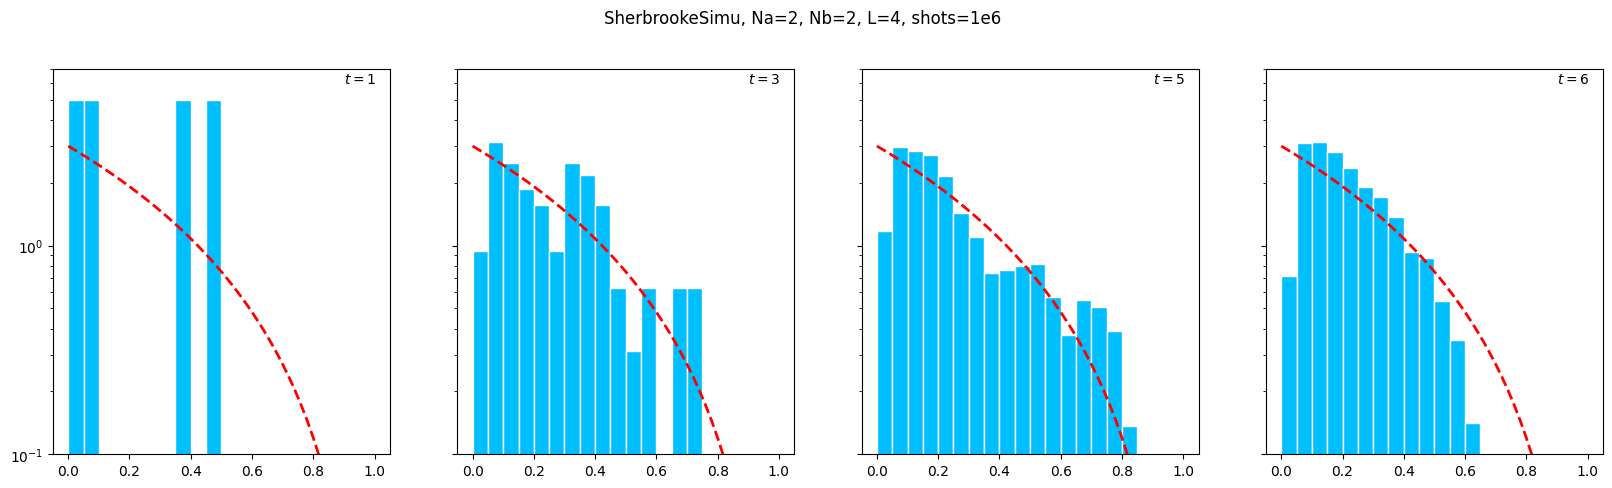

In [29]:
n_data, n_bath = 2, 2
n_depth = n_data + n_bath
step = [1, 3, 5, 6]

path = f'data/experiment/PoP/sherbrookeSimu/Na{n_data}'
condP = np.load(os.path.join(path, f'condP_Na{n_data}Nb{n_bath}L{n_depth}.npz'))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white')
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].text(0.9, 6, fr'$t={step[i]}$')
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 7)

fig.suptitle(f'SherbrookeSimu, Na={n_data}, Nb={n_bath}, L={n_depth}, shots=1e6', y=1.)

Text(0.5, 1.0, 'Noiseless, Na=4, Nb=4, L=8, shots=1e6')

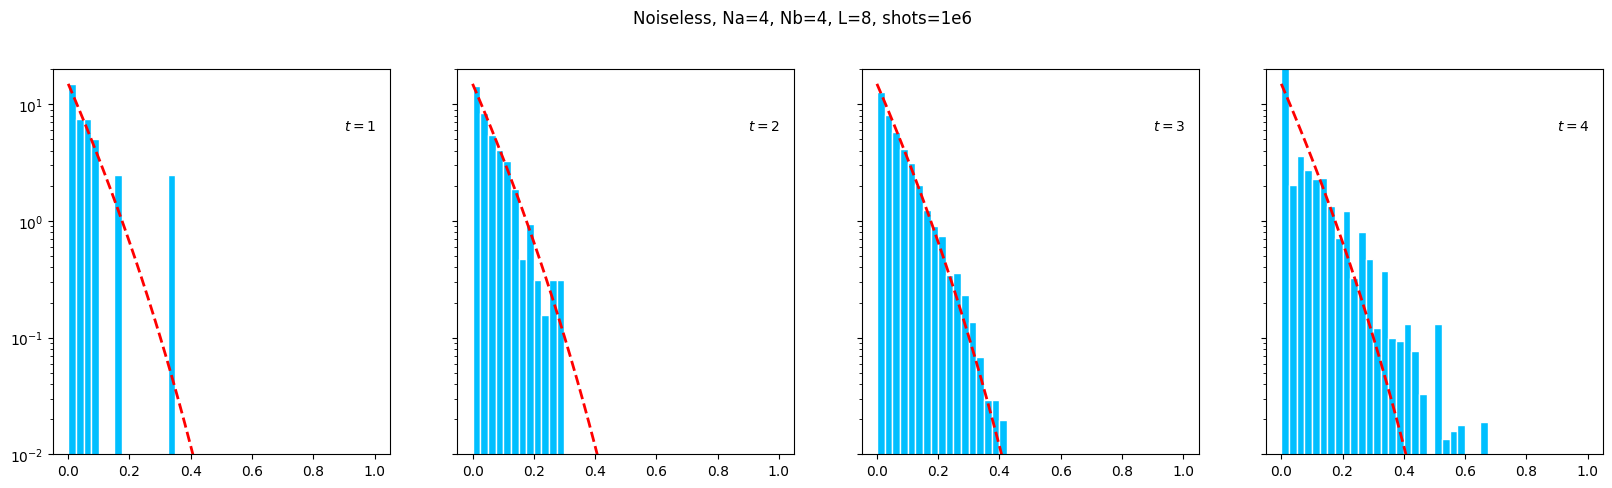

In [4]:
n_data, n_bath = 4, 4
n_depth = n_data + n_bath
step = [1, 2, 3, 4]

path = f'data/experiment/PoP/ideal/Na{n_data}'
condP = np.load(os.path.join(path, f'condP_Na{n_data}Nb{n_bath}L{n_depth}.npz'))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 41), density=True, color='deepskyblue', edgecolor='white')
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].text(0.9, 6, fr'$t={step[i]}$')
axs[0].set_yscale('log')
axs[0].set_ylim(0.01, 20)

fig.suptitle(f'Noiseless, Na=4, Nb=4, L=8, shots=1e6', y=1.)

Text(0.5, 1.0, 'SherbrookeSimu, Na=4, Nb=4, L=8, shots=1e6')

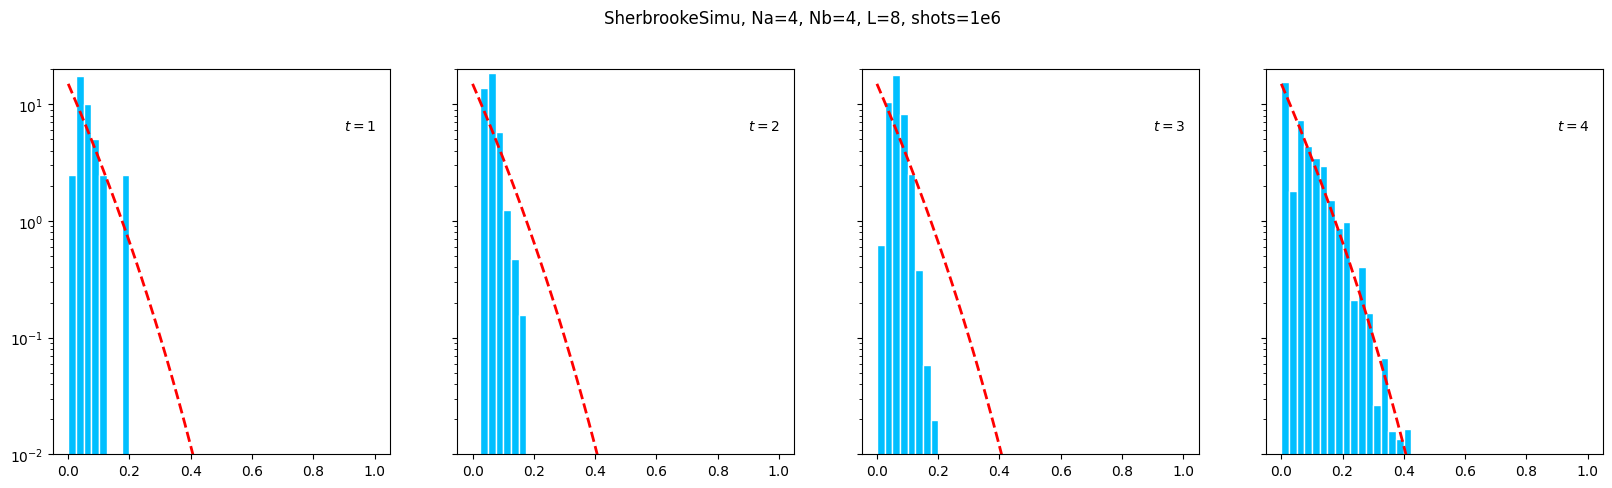

In [30]:
n_data, n_bath = 4, 4
n_depth = n_data + n_bath
step = [1, 2, 3, 4]

path = f'data/experiment/PoP/sherbrookeSimu/Na{n_data}'
condP = np.load(os.path.join(path, f'condP_Na{n_data}Nb{n_bath}L{n_depth}.npz'))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 41), density=True, color='deepskyblue', edgecolor='white')
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
    axs[i].text(0.9, 6, fr'$t={step[i]}$')
axs[0].set_yscale('log')
axs[0].set_ylim(0.01, 20)

fig.suptitle(f'SherbrookeSimu, Na={n_data}, Nb={n_bath}, L={n_depth}, shots=1e6', y=1.)

Text(0.5, 0.95, 'Noiseless, Na=5, Nb=4, L=9, shots=1e5')

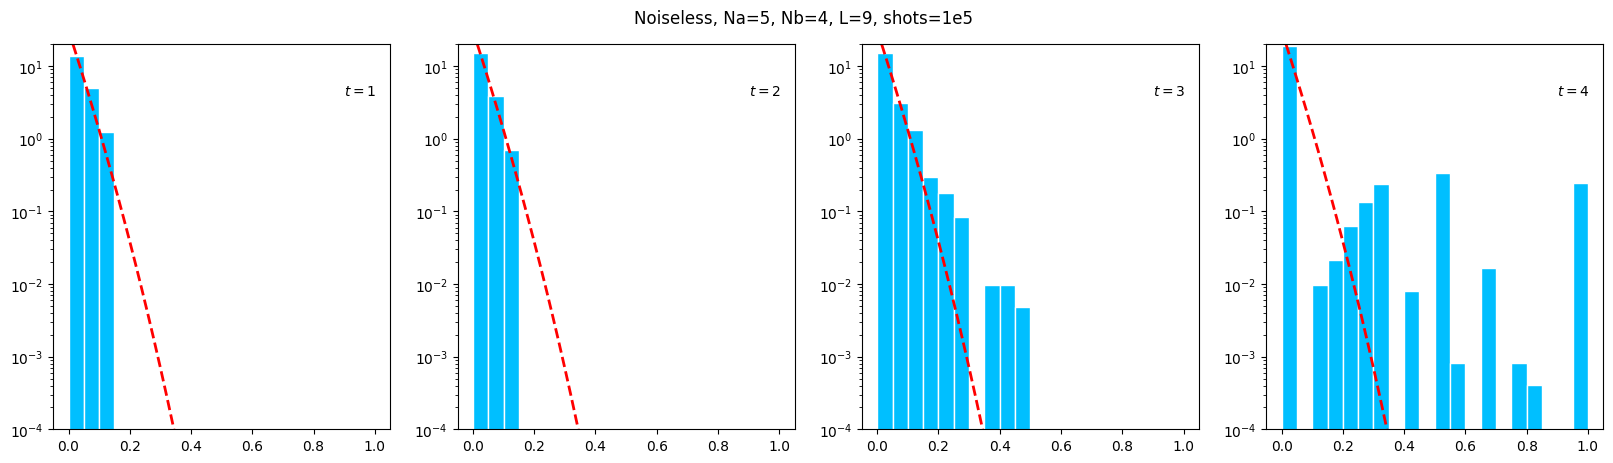

In [115]:
n_data, n_bath = 5, 4

condP = np.load(f'data/experiment/PoP/ideal/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data+n_bath}_s1e5.npz')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-4, 20)
    axs[i].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'Noiseless, Na={n_data}, Nb={n_bath}, L={n_data+n_bath}, shots=1e5', y=0.95)

Text(0.5, 0.95, 'sherbrooke Simu, Na=5, Nb=4, L=9, shot=1e5')

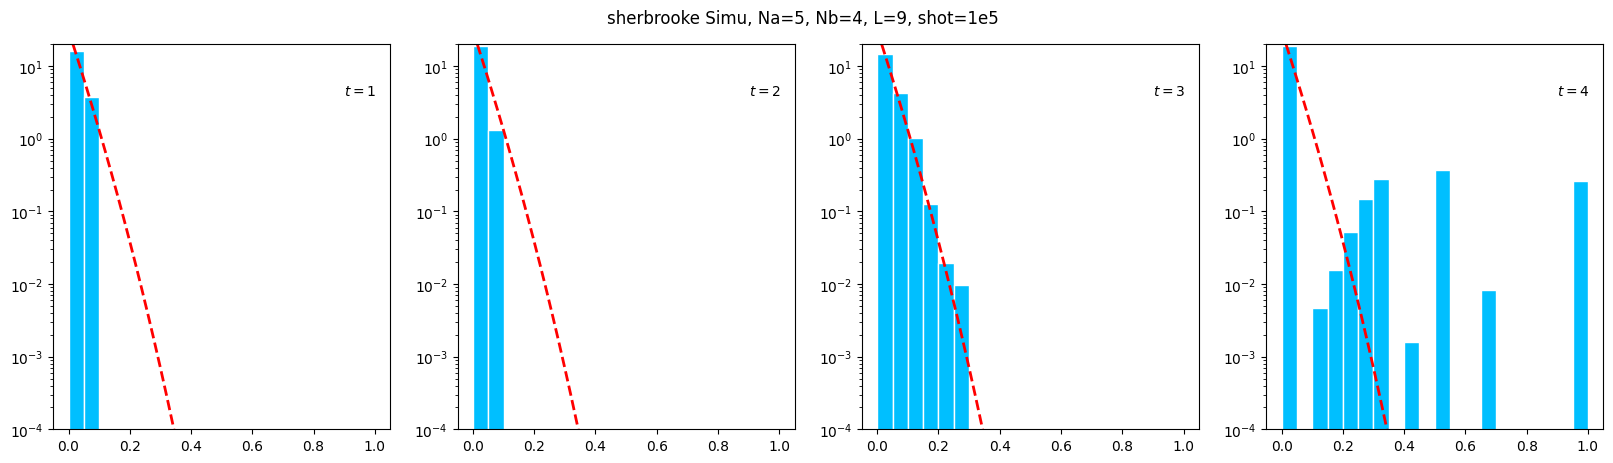

In [114]:
backend_name = 'sherbrooke'
n_data, n_bath = 5, 4

condP = np.load(f'data/experiment/PoP/{backend_name}Simu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data+n_bath}_s1e5_{backend_name}Simu2.npz')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-4, 20)
    axs[i].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'{backend_name} Simu, Na={n_data}, Nb={n_bath}, L={n_data+n_bath}, shot=1e5', y=0.95)

Text(0.5, 0.95, 'Noiseless, Na=6, Nb=4, L=10, shots=1e5')

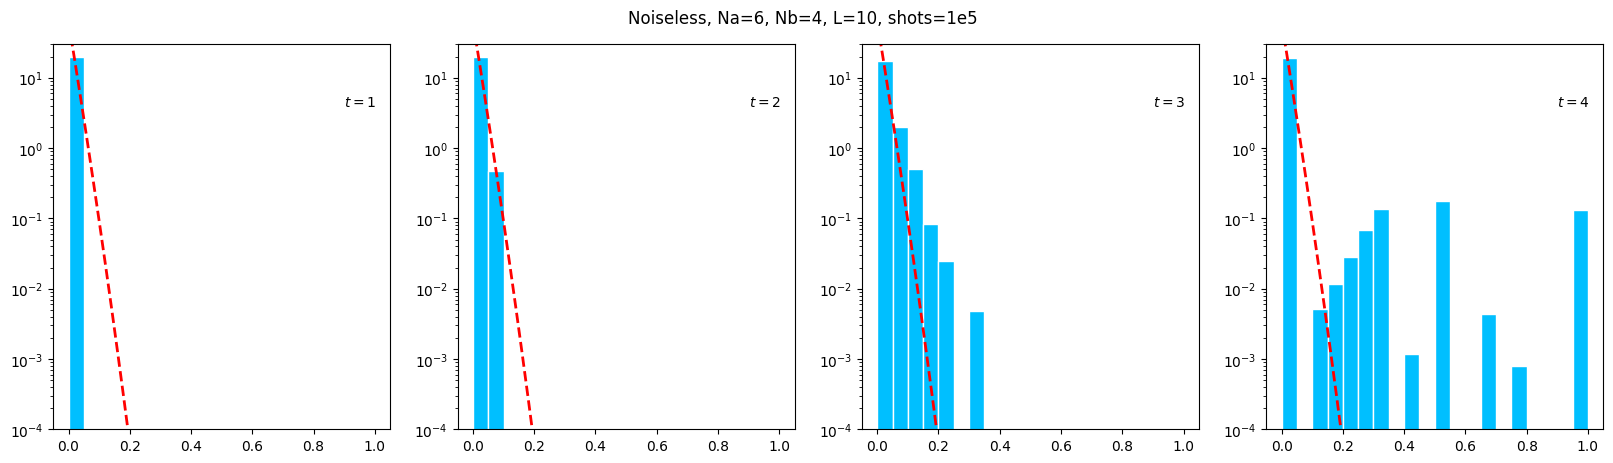

In [117]:
n_data, n_bath = 6, 4

condP = np.load(f'data/experiment/PoP/ideal/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data+n_bath}_s1e5.npz')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-4, 30)
    axs[i].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'Noiseless, Na={n_data}, Nb={n_bath}, L={n_data+n_bath}, shots=1e5', y=0.95)

Text(0.5, 0.95, 'sherbrooke Simu, Na=6, Nb=4, L=10, shot=1e5')

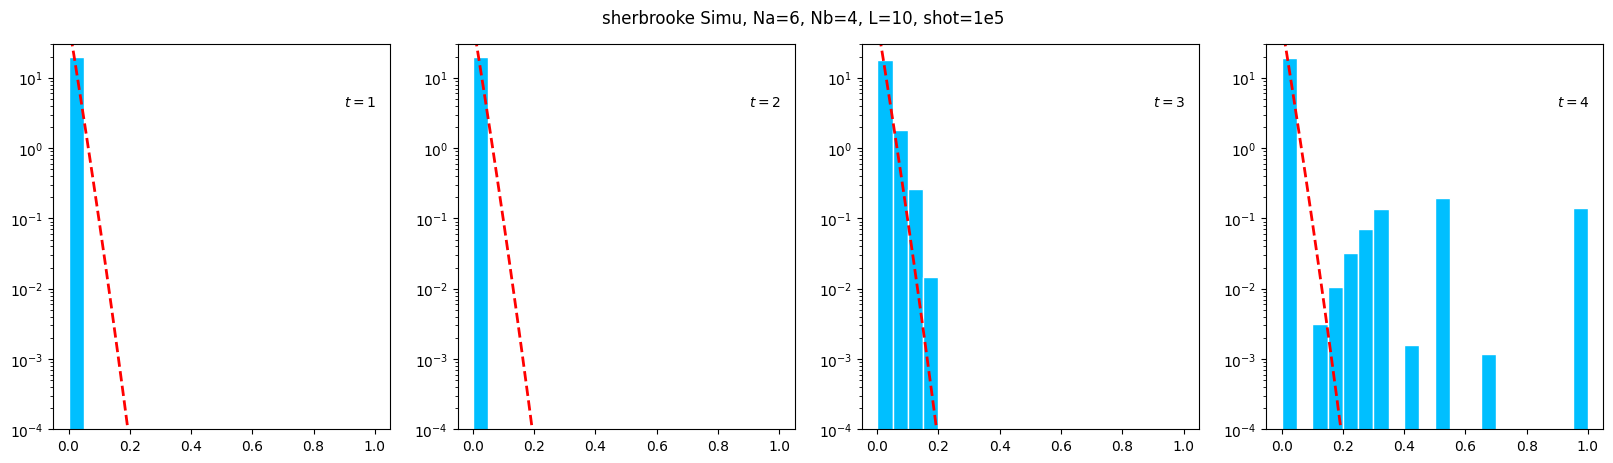

In [119]:
backend_name = 'sherbrooke'
n_data, n_bath = 6, 4

condP = np.load(f'data/experiment/PoP/{backend_name}Simu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_data+n_bath}_s1e5_{backend_name}Simu2.npz')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-4, 30)
    axs[i].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'{backend_name} Simu, Na={n_data}, Nb={n_bath}, L={n_data+n_bath}, shot=1e5', y=0.95)

# Experimental results

In [14]:
# merged result
n_data, n_bath = 5, 3
n_depth = n_data + n_bath
steps= [1, 2, 4]

condP = []
for step in steps:
    res = json.load(open(f'data/experiment/PoP/brisbane/Na{n_data}/QBCount_Brisbane_{n_data}A_{n_bath}B_{step}T_merge.json'))
    phat = get_cond_prob(res, n_data)
    condP.append(phat)
np.savez(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz', *condP)

np.float64(0.010827449613563987)

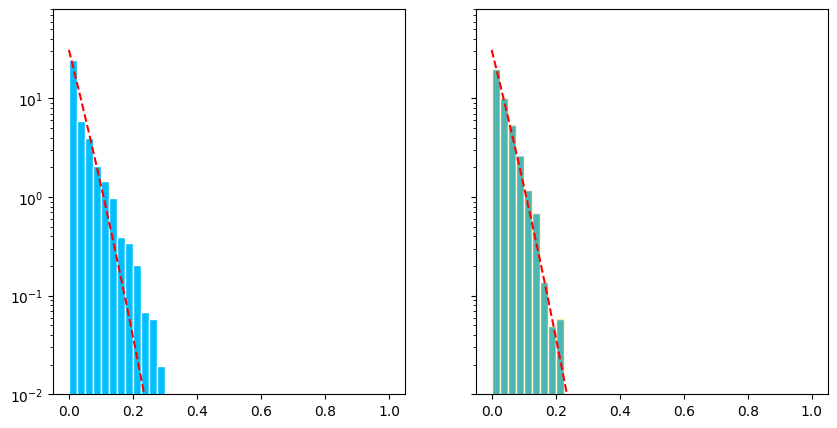

In [155]:
n_data, n_bath = 5, 3
n_depth = n_data + n_bath
step = 4

path = f'data/experiment/PoP/ideal/Na{n_data}'
with open(os.path.join(path, f'count_Na{n_data}Nb{n_bath}L{n_depth}.pkl'), 'rb') as file:
    load_data = pickle.load(file)

#res = json.load(open(f'data/experiment/PoP/brisbane/Na{n_data}/QBCount_Brisbane_{n_data}A_{n_bath}B_{step}T_merge.json'))
res = json.load(open(f'data/experiment/PoP/brisbane/Na{n_data}/counts/QBCount_Brisbane_{n_data}A_{n_bath}B_{step}T_8.json'))

res_clip = count_clip(res, n_data, 12)

condP_id = get_cond_prob(load_data[-1], n_data)
condP = get_cond_prob(res, n_data)
condP_clip = get_cond_prob(res_clip, n_data)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

bins = 41
axs[0].hist(condP_id, bins=np.linspace(0, 1, bins), density=True,  edgecolor='white', color='deepskyblue')
axs[0].plot(np.linspace(0, 1, 51), pt_density(np.linspace(0, 1, 51), n_data), '--', c='r')

axs[1].hist(condP, bins=np.linspace(0, 1, bins), density=True,  edgecolor='white', color='deepskyblue')
axs[1].hist(condP_clip, bins=np.linspace(0, 1, bins), density=True,  edgecolor='white', color='orange', alpha=0.3)
axs[1].plot(np.linspace(0, 1, 51), pt_density(np.linspace(0, 1, 51), n_data), '--', c='r')
axs[1].set_yscale('log')
axs[1].set_ylim(0.01, 80)

hist, bin_edges = np.histogram(condP, bins=np.linspace(0, 1, bins), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
entropy(hist, pt_density(bin_centers, n_data))

np.float64(39.66075840071485)

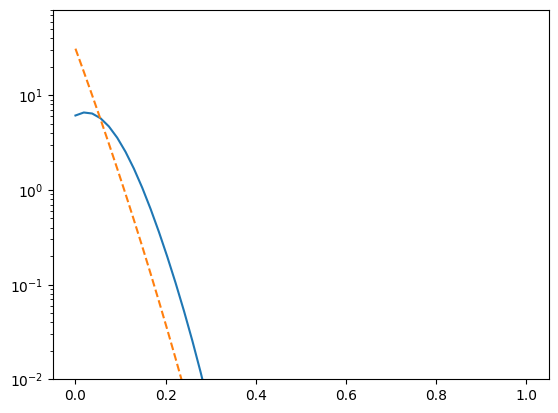

In [163]:
x = np.linspace(0, 1, 55)
pdf_g = gaussian_pdf(x, condP, 0.05)
plt.plot(x, pdf_g)
plt.plot(x, pt_density(x, n_data), '--')
plt.yscale('log')
plt.ylim(0.01, 80)

sum(pdf_g)

Gaussian KS stat=0.24304204837422816, p-value=0.01449567445218558
Grid KS stat=0.17001589861148214, p-value=0.17623500378974777


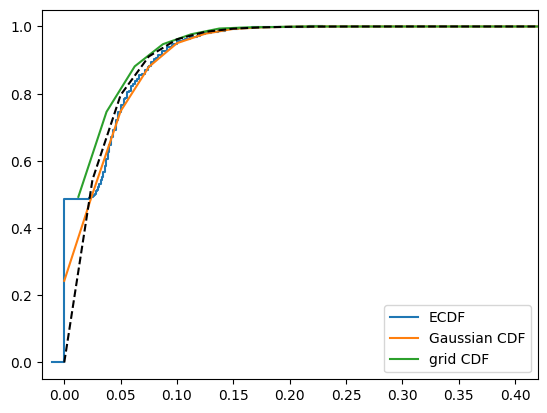

In [137]:
x = np.linspace(0, 1, 41)
cdf_g = gaussian_cdf(x, condP, 0.005)

h, b = np.histogram(condP, bins=x, density=True)
cdf_grid = np.cumsum(h * np.diff(b))

fig, ax = plt.subplots()
ecdf(condP).cdf.plot(ax, label='ECDF')
ax.plot(x, cdf_g, label='Gaussian CDF')
ax.plot((b[1:]+b[:-1])/2, cdf_grid, label='grid CDF')
ax.plot(x, 1. - (1.-x)**(2**n_data-1), '--', c='k')
ax.legend()
ax.set_xlim(-0.02, 0.42)

ks_g = np.max(np.abs(cdf_g - pt_cdf(x, n_data)))
ks_grid = np.max(cdf_grid - pt_cdf((b[1:]+b[:-1])/2, n_data))

print(f'Gaussian KS stat={ks_g}, p-value={kstwo.sf(np.max(cdf_g - pt_cdf(x, n_data)), len(x)-1)}')
print(f'Grid KS stat={ks_grid}, p-value={kstwo.sf(np.max(cdf_grid - pt_cdf((b[1:]+b[:-1])/2, n_data)), len(x)-1)}')

In [75]:
from scipy.stats import kstwo

kstwo.sf(0.1861372380923315, len(x))

np.float64(0.10231498939394479)

Text(0.5, 0.95, 'IBM brisbane, Na=2, Nb=2, L=4, shots=1e6')

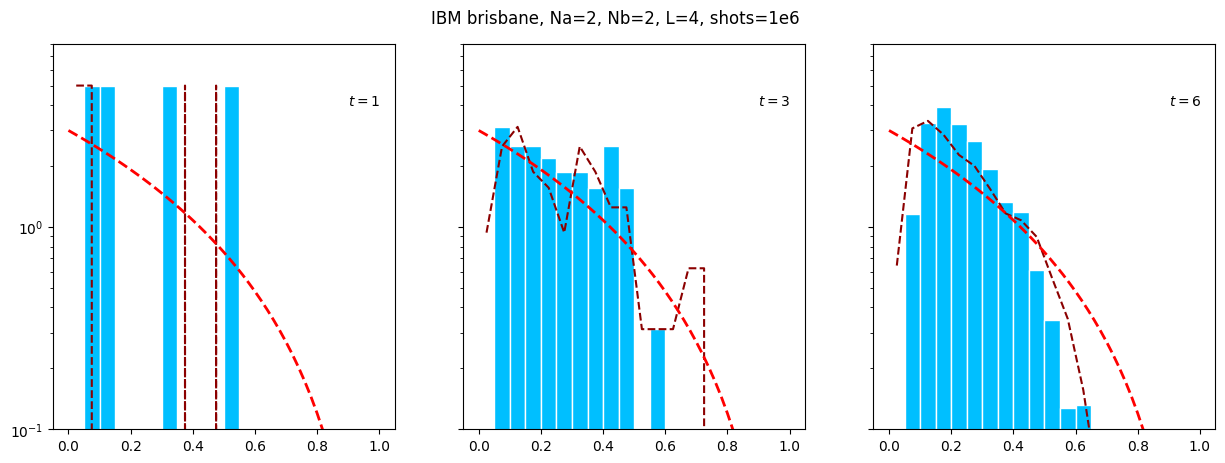

In [48]:
n_data, n_bath = 2, 2
n_depth = n_data + n_bath
steps = [1, 3, 6]

condP = np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz')
condP_simu = np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz')

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True, color='deepskyblue', edgecolor='white',
                label='$t={}$'.format(steps[i]))
    h, b = np.histogram(condP_simu[f'arr_{i}'], bins=np.linspace(0, 1, 21), density=True)
    axs[i].plot((b[1:]+b[:-1])/2, h, '--', c='darkred')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].text(0.9, 4, '$t={}$'.format(steps[i]))
axs[0].set_ylim(0.1, 8)
fig.suptitle('IBM brisbane, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, '1e6'), y=0.95)

Text(0.5, 0.95, 'IBM brisbane, Na=2, Nb=2, L=4, shots=1e5')

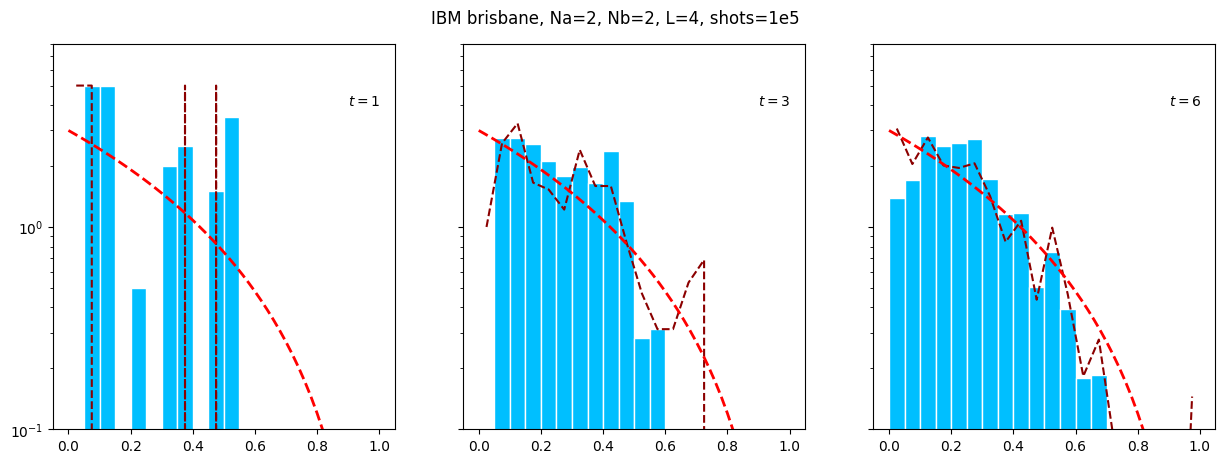

In [185]:
n_data, n_bath = 2, 2
n_depth = n_data + n_bath
steps = [1, 3, 6]

condP = []
condP_simu = []
for step in steps:
    condP.append(np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}T{step}.npz'))
    condP_simu.append(np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}T{step}.npz'))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    h, h_s = np.zeros((10, 20)), np.zeros((10, 20))
    for j in range(10):
        h[j], b = np.histogram(condP[i][f'arr_{j}'], bins=np.linspace(0, 1, 21), density=True)
        h_s[j], b_s = np.histogram(condP_simu[i][f'arr_{j}'], bins=np.linspace(0, 1, 21), density=True)

    axs[i].bar((b[1:]+b[:-1])/2, np.mean(h, axis=0), color='deepskyblue', width=b[1]-b[0], edgecolor='white')
    axs[i].plot((b_s[1:]+b_s[:-1])/2, np.mean(h_s, axis=0), '--', c='darkred')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].text(0.9, 4, '$t={}$'.format(steps[i]))
axs[0].set_ylim(0.1, 8)
fig.suptitle('IBM brisbane, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, '1e5'), y=0.95)

Text(0.5, 0.95, 'IBM brisbane, Na=4, Nb=2, L=6, shots=1e6')

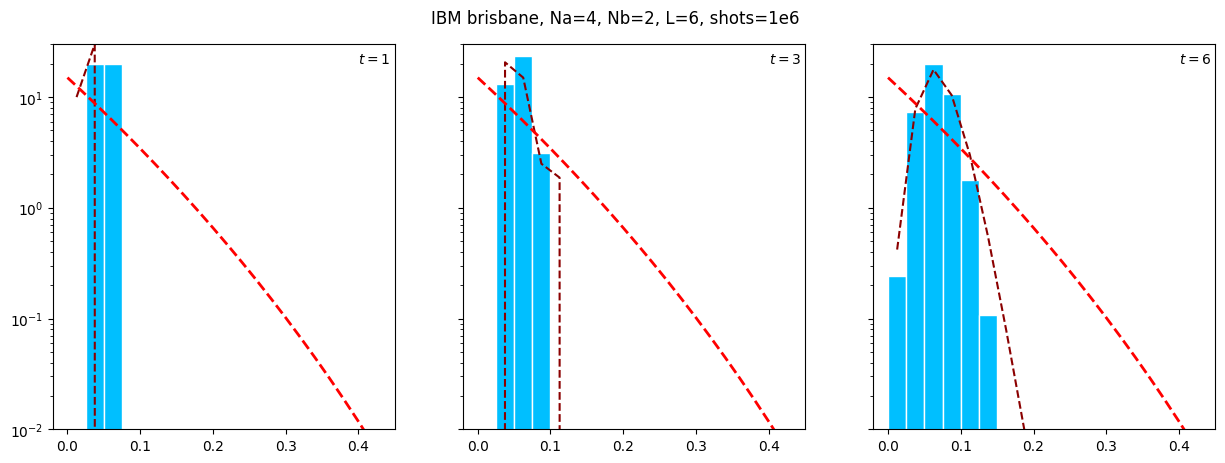

In [96]:
n_data, n_bath = 4, 2
n_depth = n_data + n_bath
steps = [1, 3, 6]

condP = np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz')
condP_simu = np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz')

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 41), density=True, color='deepskyblue', edgecolor='white',
                label='$t={}$'.format(steps[i]))
    h, b = np.histogram(condP_simu[f'arr_{i}'], bins=np.linspace(0, 1, 41), density=True)
    axs[i].plot((b[1:]+b[:-1])/2, h, '--', c='darkred')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].text(0.4, 20, '$t={}$'.format(steps[i]))
axs[0].set_ylim(0.01, 30)
axs[0].set_xlim(-0.02, 0.45)
fig.suptitle('IBM brisbane, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, '1e6'), y=0.95)

Text(0.5, 0.95, 'IBM brisbane, Na=4, Nb=2, L=6, shots=1e5')

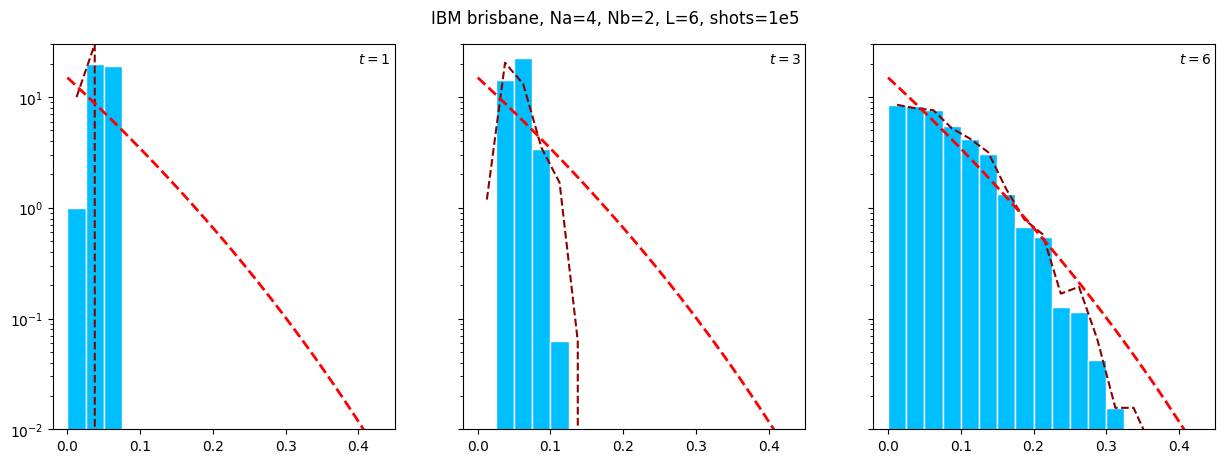

In [186]:
n_data, n_bath = 4, 2
n_depth = n_data + n_bath
steps = [1, 3, 6]

condP = []
condP_simu = []
for step in steps:
    condP.append(np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}T{step}.npz'))
    condP_simu.append(np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}T{step}.npz'))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    h, h_s = np.zeros((10, 40)), np.zeros((10, 40))
    for j in range(10):
        h[j], b = np.histogram(condP[i][f'arr_{j}'], bins=np.linspace(0, 1, 41), density=True)
        h_s[j], b_s = np.histogram(condP_simu[i][f'arr_{j}'], bins=np.linspace(0, 1, 41), density=True)

    axs[i].bar((b[1:]+b[:-1])/2, np.mean(h, axis=0), color='deepskyblue', width=b[1]-b[0], edgecolor='white')
    axs[i].plot((b_s[1:]+b_s[:-1])/2, np.mean(h_s, axis=0), '--', c='darkred')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].text(0.4, 20, '$t={}$'.format(steps[i]))
axs[0].set_ylim(0.01, 30)
axs[0].set_xlim(-0.02, 0.45)
fig.suptitle('IBM brisbane, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, '1e5'), y=0.95)

Text(0.5, 0.95, 'IBM brisbane, Na=5, Nb=3, L=8, shots=1e6')

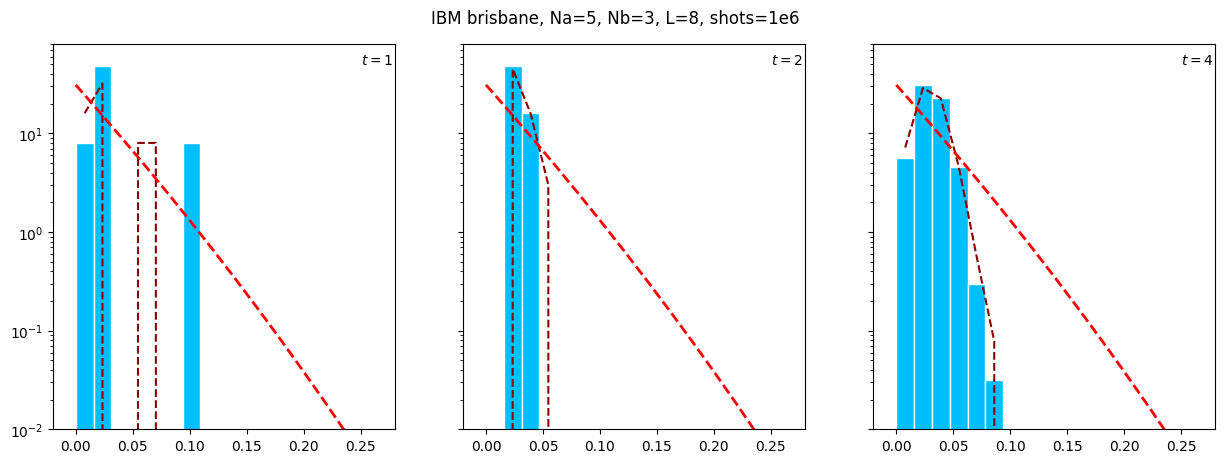

In [91]:
n_data, n_bath = 5, 3
n_depth = n_data + n_bath
steps = [1, 2, 4]

condP = np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz')
condP_simu = np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}_merge.npz')

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    axs[i].hist(condP[f'arr_{i}'], bins=np.linspace(0, 1, 65), density=True, color='deepskyblue', edgecolor='white',
                label='$t={}$'.format(steps[i]))
    h, b = np.histogram(condP_simu[f'arr_{i}'], bins=np.linspace(0, 1, 65), density=True)
    axs[i].plot((b[1:]+b[:-1])/2, h, '--', c='darkred')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].text(0.25, 50, '$t={}$'.format(steps[i]))
axs[0].set_ylim(0.01, 80)
axs[0].set_xlim(-0.02, 0.28)
fig.suptitle('IBM brisbane, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, '1e6'), y=0.95)

Text(0.5, 0.95, 'IBM brisbane, Na=5, Nb=3, L=8, shots=1e5')

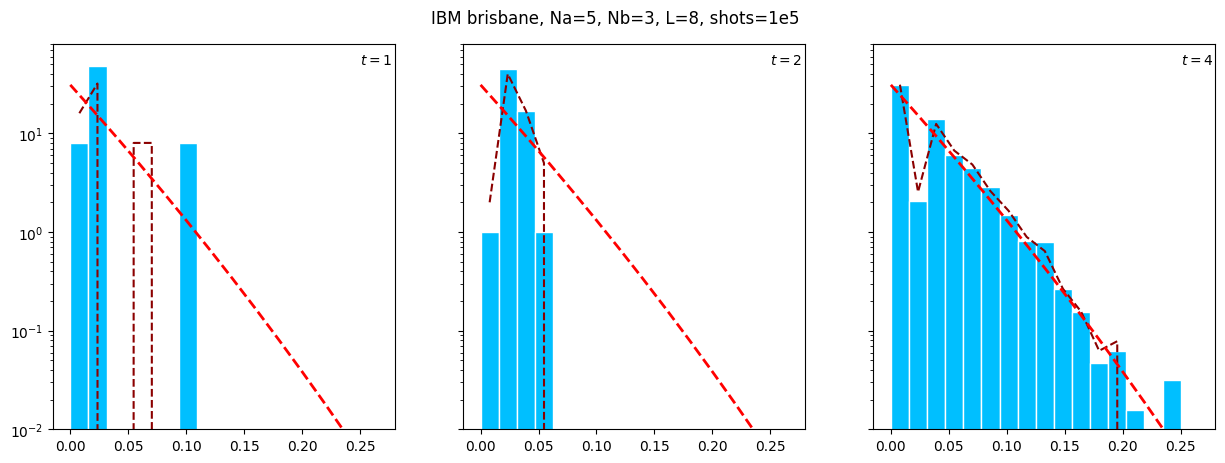

In [90]:
n_data, n_bath = 5, 3
n_depth = n_data + n_bath
steps = [1, 2, 4]

condP = []
condP_simu = []
for step in steps:
    condP.append(np.load(f'data/experiment/PoP/brisbane/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}T{step}.npz'))
    condP_simu.append(np.load(f'data/experiment/PoP/brisbaneSimu/Na{n_data}/condP_Na{n_data}Nb{n_bath}L{n_depth}T{step}.npz'))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    h, h_s = np.zeros((10, 64)), np.zeros((10, 64))
    for j in range(10):
        h[j], b = np.histogram(condP[i][f'arr_{i}'], bins=np.linspace(0, 1, 65), density=True)
        h_s[j], b_s = np.histogram(condP_simu[i][f'arr_{i}'], bins=np.linspace(0, 1, 65), density=True)

    axs[i].bar((b[1:]+b[:-1])/2, np.mean(h, axis=0), color='deepskyblue', width=b[1]-b[0], edgecolor='white')
    axs[i].plot((b_s[1:]+b_s[:-1])/2, np.mean(h_s, axis=0), '--', c='darkred')
    axs[i].plot(qs, (2**n_data - 1)*(1-qs)**(2**n_data-2), '--', lw=2, color='r')
    axs[i].set_yscale('log')
    axs[i].text(0.25, 50, '$t={}$'.format(steps[i]))
axs[0].set_ylim(0.01, 80)
axs[0].set_xlim(-0.015, 0.28)
fig.suptitle('IBM brisbane, Na={}, Nb={}, L={}, shots={}'.format(n_data, n_bath, n_depth, '1e5'), y=0.95)